<a href="https://colab.research.google.com/github/muhammadfawad538/CNN/blob/main/Dog_Cat_classification_through_Transfer_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Choose kaggle.json


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"saumaya","key":"6a9a6991b3bd9614f63f102ed3c24d5e"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d tongpython/cat-and-dog


Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 59% 128M/218M [00:00<00:00, 1.33GB/s]
100% 218M/218M [00:00<00:00, 851MB/s] 


In [4]:
import zipfile

zip_path = "/content/cat-and-dog.zip"  # downloaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")


In [5]:
import os, shutil

# Adjust this to the folder that contains all images (from previous listing)
# e.g., extract_to + "/train" or extract_to (where cat.0.jpg files are)
images_dir = "/content/data/training_set/training_set"   # change if different
if not os.path.exists(images_dir):
    # Try other common locations
    possible = [os.path.join(extract_to, d) for d in os.listdir(extract_to)]
    print("Possible top-level folders:", possible[:10])
    # update images_dir manually if needed
    # images_dir = possible[0]  # <--- set this if you want
else:
    print("Images folder found:", images_dir)

# Make target directories
base_out = "/content/data"  # final root for data
train_root = os.path.join(base_out, "train_all")  # we'll split later
os.makedirs(train_root, exist_ok=True)
os.makedirs(os.path.join(train_root, "cat"), exist_ok=True)
os.makedirs(os.path.join(train_root, "dog"), exist_ok=True)

# Move files based on filename prefix
moved=0
for fname in os.listdir(images_dir):
    if fname.lower().startswith("cat"):
        shutil.move(os.path.join(images_dir, fname), os.path.join(train_root, "cat", fname))
        moved+=1
    elif fname.lower().startswith("dog"):
        shutil.move(os.path.join(images_dir, fname), os.path.join(train_root, "dog", fname))
        moved+=1

print("Moved files:", moved)
# If your zip already had class subfolders, you can copy them to train_root instead.


Images folder found: /content/data/training_set/training_set
Moved files: 2


In [6]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image

data_root = "/content/data/train_all"  # path created above
print("Data root:", data_root)
assert os.path.exists(data_root), "data_root not found — update path"

# Transforms
input_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(int(input_size*1.14)),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Full dataset using ImageFolder (initially with train_transform)
full_dataset = datasets.ImageFolder(data_root, transform=train_transform)
print("Total images:", len(full_dataset))
class_names = full_dataset.classes
print("Classes:", class_names)

# Split 80% train / 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Subset wrapper to apply different transforms for val
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        self.dataset = subset.dataset  # ImageFolder
        self.indices = subset.indices  # indices inside the ImageFolder.samples
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        path, label = self.dataset.samples[self.indices[idx]]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = SubsetWithTransform(train_subset, train_transform)
val_dataset = SubsetWithTransform(val_subset, val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Train size:", len(train_dataset), "Val size:", len(val_dataset))


Data root: /content/data/train_all
Total images: 8005
Classes: ['cat', 'dog']
Train size: 6404 Val size: 1601


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load pretrained VGG16 (compat for old/new torchvision)
try:
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
except Exception:
    vgg = models.vgg16(pretrained=True)

# Freeze feature extractor
for param in vgg.features.parameters():
    param.requires_grad = False

# Replace classifier with smaller head for binary classification
num_classes = len(class_names)  # should be 2
vgg.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

model = vgg.to(device)
print(model.classifier)


Device: cuda


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 173MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=2, bias=True)
)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# Only train classifier params
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
# Scheduler to reduce LR every few epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import time, copy
import os

# ========================
# 🔧 SETTINGS
# ========================
data_dir = "/content/data/train_all"  # replace with your extracted dataset folder
batch_size = 16
num_epochs = 3  # fewer epochs for CPU
img_size = 128  # smaller image size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================
# 📦 DATA AUGMENTATION
# ========================
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# ✅ Dynamically calculate split sizes to avoid ValueError
train_size = int(0.7 * len(full_dataset))  # 70% train
val_size = len(full_dataset) - train_size  # rest validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ========================
# 🧠 TRANSFER LEARNING (VGG16)
# ========================
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# ========================
# 🚀 TRAINING LOOP
# ========================
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print('-' * 30)

    # Train phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader, 1):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total_train += inputs.size(0)

        # Show progress per batch
        batch_acc = torch.sum(preds == labels.data).item() / inputs.size(0)
        # print(f" Batch [{batch_idx}/{len(train_loader)}] - Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}") # Removed for brevity

    epoch_loss = running_loss / total_train
    epoch_acc = running_corrects / total_train

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()
            total_val += inputs.size(0)

    val_epoch_loss = val_loss / total_val
    val_epoch_acc = val_corrects / total_val

    scheduler.step()

    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_vgg16_dogs_cats.pth")

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

print("\n✅ Best Val Accuracy:", best_acc)
model.load_state_dict(best_model_wts)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [1/3]
------------------------------
Train Loss: 1.9211 Acc: 0.9175 | Val Loss: 2.0418 Acc: 0.9342

Epoch [2/3]
------------------------------
Train Loss: 1.5516 Acc: 0.9420 | Val Loss: 0.8970 Acc: 0.9638

Epoch [3/3]
------------------------------
Train Loss: 0.5434 Acc: 0.9650 | Val Loss: 0.3424 Acc: 0.9613

✅ Best Val Accuracy: 0.9637801831806828


<All keys matched successfully>

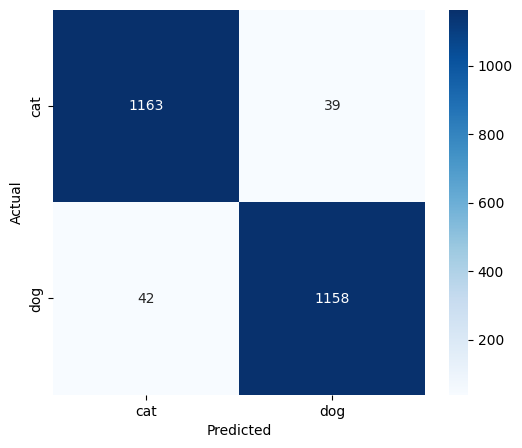

Classification Report:
               precision    recall  f1-score   support

         cat       0.97      0.97      0.97      1202
         dog       0.97      0.96      0.97      1200

    accuracy                           0.97      2402
   macro avg       0.97      0.97      0.97      2402
weighted avg       0.97      0.97      0.97      2402

cat: 96.76%
dog: 96.50%


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, cls in enumerate(class_names):
    print(f"{cls}: {per_class_acc[i]*100:.2f}%")


In [16]:
import torch
import torch.nn.functional as F
from PIL import Image
import os

# Prediction function
def predict_image(image_path, model, transform, class_names):
    img = Image.open(image_path).convert('RGB')
    inp = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(inp)
        probs = F.softmax(out, dim=1).cpu().numpy()[0]

    # Get best prediction
    top_idx = probs.argmax()
    pred_class = class_names[top_idx]
    pred_conf = probs[top_idx]

    # Print all probabilities
    print("\n🔍 Prediction Results:")
    for cls, p in zip(class_names, probs):
        print(f"{cls}: {p*100:.2f}%")

    return pred_class, pred_conf


# ---- USAGE EXAMPLE ----
# Just replace 'your_image.jpg' with the path of the uploaded image
uploaded_image_path = "/content/data/train_all/cat/cats/cat.10.jpg"  # <- change this after upload

if os.path.exists(uploaded_image_path):
    pred_class, conf = predict_image(uploaded_image_path, model, val_transform, class_names)
    print(f"\n✅ Final Prediction: {pred_class} ({conf*100:.2f}% confidence)")
else:
    print("❌ Image file not found. Please upload first.")



🔍 Prediction Results:
cat: 100.00%
dog: 0.00%

✅ Final Prediction: cat (100.00% confidence)


In [18]:
import torch
import torch.nn.functional as F
from PIL import Image
import os

# Prediction function
def predict_image(image_path, model, transform, class_names):
    img = Image.open(image_path).convert('RGB')
    inp = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(inp)
        probs = F.softmax(out, dim=1).cpu().numpy()[0]

    # Get best prediction
    top_idx = probs.argmax()
    pred_class = class_names[top_idx]
    pred_conf = probs[top_idx]

    # Print all probabilities
    print("\n🔍 Prediction Results:")
    for cls, p in zip(class_names, probs):
        print(f"{cls}: {p*100:.2f}%")

    return pred_class, pred_conf


# ---- USAGE EXAMPLE ----
# Just replace 'your_image.jpg' with the path of the uploaded image
uploaded_image_path = "/content/data/train_all/dog/dogs/dog.1002.jpg"  # <- change this after upload

if os.path.exists(uploaded_image_path):
    pred_class, conf = predict_image(uploaded_image_path, model, val_transform, class_names)
    print(f"\n✅ Final Prediction: {pred_class} ({conf*100:.2f}% confidence)")
else:
    print("❌ Image file not found. Please upload first.")



🔍 Prediction Results:
cat: 0.00%
dog: 100.00%

✅ Final Prediction: dog (100.00% confidence)
